# Simple Gaussian Processes

This notebook is intended to complement the introductory lecture on Gaussian Processes.  We'll first look at Gaussian Processes in the context of the interpolation of missing data we did in the previous notebook, then move onto demonstrating a 1D application of Gaussian Process regression in context of various sparse datasets.

Let's get our libraries first:

In [1]:
import math
import numpy as np 
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt 

# switch font default to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

Once again, let's create a simulated time series as a sine function of 64 time steps ('years).  We'l also remove some parts of the time series again and plot the function and the function with missing data:

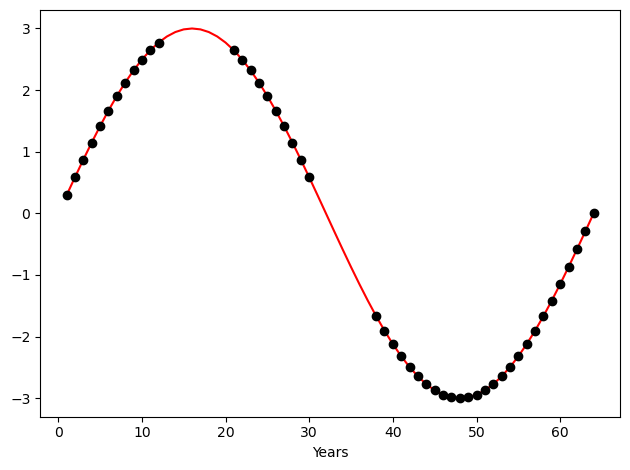

In [3]:
# we'll use 64 time points 
n_samples = 64

# Create our time vector - e.g. 64 years long
t = np.arange(1, n_samples+1)

# Create a sine wave with frequency set to the variable cycles_per_time 
cycles_per_time = 2
cycle_amplitude = 3 
u = 2 * np.pi * (cycles_per_time/128) * t

# here is our simulated time seres
st = cycle_amplitude * np.sin(u)

# create a copy using Numpy of st that we can remove some data from
stm = st.copy()

# remove two chunks of data from stm and replace with NaNs
stm[12:20] = np.nan
stm[30:37] = np.nan    
    
# Plot the original time series and the stm series with NaN values
plt.figure()
plt.plot(t, st, 'r-')
plt.plot(t, stm, 'ko')
plt.xlabel('Years')
plt.tight_layout()

There are various libraries available in the Python ecosystem for Gaussian Processes (regression and classification).  Here we'll use scikit-learn again, which has a broad range of functionality for [Gaussian Processes](https://scikit-learn.org/1.5/modules/gaussian_process.html) and specifically the [`GaussianProcessRegressor`](https://scikit-learn.org/dev/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).   We'll also need to get kernels (or covariance functions) from `sklearn.gaussian_process.kernels`.  Here we'll get the Constant kernel and the Radial Basis Function ([RBF](https://scikit-learn.org/1.5/modules/generated/sklearn.gaussian_process.kernels.RBF.html)) kernel:

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel 

We're going to apply the `GaussianProcessRegressor` to our missing data function above.  The first thing we do is find the valid (not-missing) element in the function to train the Gaussian Process.  We then declare a very simple kernel - a RBF (discussed in lecture) with the default starting length scale and the default length scale range for the model fit to consider (default is: length_scale_bounds=(1e-05, 100000.0)).  

We then call the GaussianProcessRegressor to create `gp`, the object that will be used to fit and then predict from the model.  We'll use `gp.fit` to fit the model with our x-coordinate ('t') and y-value (stm).  We'll use `gp.predict` then to get the form of the Gaussian Process at all the values of the x-coordinate (even where the y-values are missing) and consider this in the same way we did the interpolation in the previous notebook:

C:\Users\mayae\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


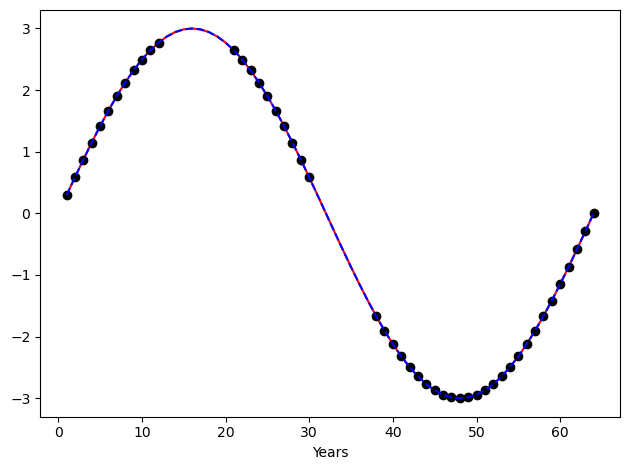

In [7]:
# get the non-missing entries in the variable to use for training
valid = ~np.isnan(stm)

# Define the kernel (RBF is common for smooth functions)
# kernel = RBF(length_scale=1.0)
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) # can define with constant here, but since data are centered doesn't have much effect


# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit the model on non-NaN data
gp.fit(t[valid].reshape(-1, 1), stm[valid])

# Predict over all data points, including NaNs
stm_gp, sigma = gp.predict(t.reshape(-1, 1), return_std=True)

# Plot the simulated noise-free time series
plt.figure()
plt.plot(t, st, 'r')
plt.plot(t, stm, 'ko')
plt.plot(t, stm_gp, 'b--')
plt.xlabel('Years')
plt.tight_layout()


This simple Gaussian Process regression find an excellent fit to the underlying function - likely because we have lots of correlated observations. 

What about if we have very few observations of the underlying function?  Interpolation of most sorts would probably struggle if we only had 4 or 5 observations of the 64 time points, but as we'll see, Gaussian Process regression can find a likely function _and_ uncertainty for that functional fit, even when observations are sparse.   

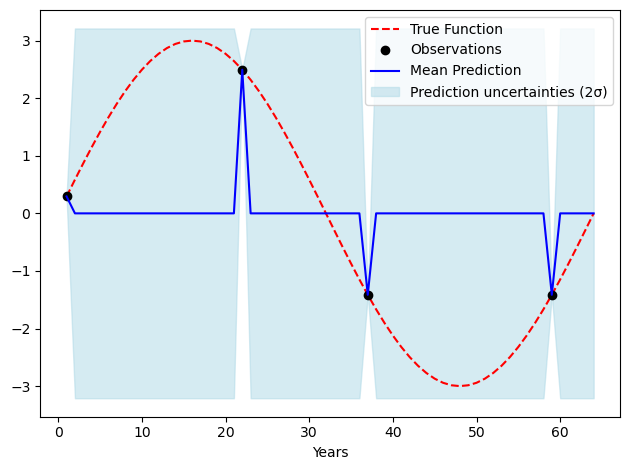

In [43]:
# create a copy using Numpy of st that we can remove some data from
stm = st.copy()

# Define the number of training points or observations to select
n_samples = 4

# Randomly select some index values to subsample our signal
random_indices = np.random.choice(len(stm), size=n_samples, replace=False)

# Extract the selected points from `stm` and `t` into new training variables
stm_train = stm[random_indices]
t_train = t[random_indices]

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit the model on non-NaN data
gp.fit(t_train.reshape(-1, 1), stm_train)

# Predict over all data points in our time vector, t
stm_gp_sparse, stm_sigma_sparse = gp.predict(t.reshape(-1, 1), return_std=True)

# Plot the simulated noise-free time series
plt.figure()
plt.plot(t, st, 'r--',label='True Function')
plt.plot(t_train, stm_train, 'ko',label='Observations')
plt.plot(t, stm_gp_sparse, 'b-',label='Mean Prediction')
plt.fill_between(t, stm_gp_sparse-(2*stm_sigma_sparse), stm_gp_sparse+(2*stm_sigma_sparse), color='lightblue', alpha=0.5,label='Prediction uncertainties (2σ)')
plt.legend()

plt.xlabel('Years')
plt.tight_layout()

We can see that the posterior solution does a good job when the underlying function is well-bounded by the few data points.  It may do OK in some instances away from those observation or between observation and the time limits, but in other cases there is a very large uncertainty (that may -- but may not -- contain the underlying function).  Because we are randomly selecting observations to retain, you can run the above code block many times and look at the various posterior solutions and the uncertainty range as a function of the observations in each random draw.

We can get the kernel that the Gaussian Process finally selected by passing the following command to the object:

In [45]:
gp.kernel_ # this allows us to see the hyper-parameters (variance from the constant, and for RBF the length scale) of the GP fit to the data


1.61**2 * RBF(length_scale=0.000371)

How might you interpet that length scale in light of the underlying true function and the limited observations?  See how much this changes for different sets of observations and posterior fits to the data. 

Above we assume that we know the observations y-value without error.  But that is seldom the case in the real world!  We can add error to our observations and also tell the Gaussian Process to expect some uncertainty by specifying a value for `alpha` -- in this case, since we can specify the noise in the observations we can also pass it to the GaussianProcessRegressor exactly (as the square of the standard deviation of the noise component).  In the real world, you'd need to have some prior information or a reasonable estimate of the noise to give to the GaussianProcessRegressor. 

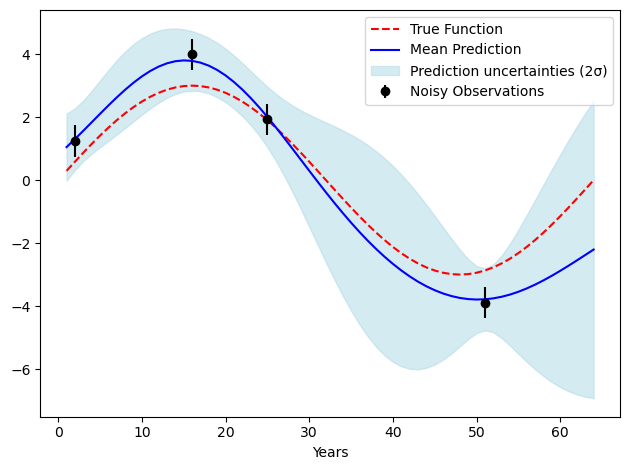

In [53]:
# create a copy using Numpy of st that we can remove some data from
stm = st.copy()

# Define the number of training points or observations to select
n_samples = 4

# Randomly select some index values to subsample our signal
random_indices = np.random.choice(len(stm), size=n_samples, replace=False)

# Extract the selected points from `stm` and `t` into new training variables
stm_train = stm[random_indices]
noise_std = 0.50
stm_train_noisy = stm_train + np.random.normal(loc=0.0, scale=noise_std, size=stm_train.shape)
t_train = t[random_indices]

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=20)

# Fit the model on non-NaN data
gp.fit(t_train.reshape(-1, 1), stm_train_noisy)

# Predict over all data points in our time vector, t
stm_gp_sparse, stm_sigma_sparse = gp.predict(t.reshape(-1, 1), return_std=True)

# Plot the simulated noise-free time series
plt.figure()
plt.plot(t, st, 'r--',label='True Function')
plt.errorbar(t_train, stm_train_noisy, noise_std, linestyle='none',color='k',marker='o',label='Noisy Observations')
plt.plot(t, stm_gp_sparse, 'b-',label='Mean Prediction')
plt.fill_between(t, stm_gp_sparse-(2*stm_sigma_sparse), stm_gp_sparse+(2*stm_sigma_sparse), color='lightblue', alpha=0.5,label='Prediction uncertainties (2σ)')
plt.legend()

plt.xlabel('Years')
plt.tight_layout()

We can see that allowing of uncertainty in the observations allows the posterior solution to 'relax' around the observations and not fit them as tightly. 

We can see if this affects the kernel hyperparameters as well:

In [55]:
gp.kernel_ # compare to various runs of the better-populated curve above where only a few values were missing - what do you notice?

2.97**2 * RBF(length_scale=13)

One last example.  What if we observe 64 time steps (no missing data) but the data are very noisy?  How does the Gaussian Process regressor do at fitting the true underlying function? 

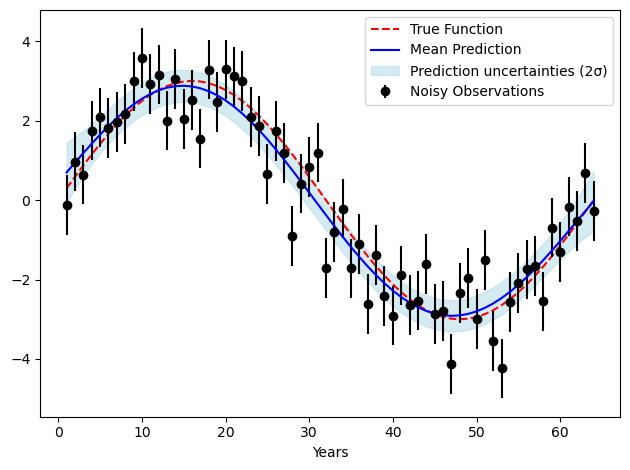

In [63]:
# create a copy using Numpy of st that we can remove some data from
stm = st.copy()

# Extract the selected points from `stm` and `t` into new training variables
stm_train = stm 
noise_std = 0.75
stm_train_noisy = stm_train + np.random.normal(loc=0.0, scale=noise_std, size=stm_train.shape)
t_train = t

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=20)

# Fit the model on non-NaN data
gp.fit(t_train.reshape(-1, 1), stm_train_noisy)

# Predict over all data points in our time vector, t
stm_gp_sparse, stm_sigma_sparse = gp.predict(t.reshape(-1, 1), return_std=True)

# Plot the simulated noise-free time series
plt.figure()
plt.plot(t, st, 'r--',label='True Function')
plt.errorbar(t_train, stm_train_noisy, noise_std, linestyle='none',color='k',marker='o',label='Noisy Observations')
plt.plot(t, stm_gp_sparse, 'b-',label='Mean Prediction')
plt.fill_between(t, stm_gp_sparse-(2*stm_sigma_sparse), stm_gp_sparse+(2*stm_sigma_sparse), color='lightblue', alpha=0.5,label='Prediction uncertainties (2σ)')
plt.legend()

plt.xlabel('Years')
plt.tight_layout()

Not too bad!  We can look at the posterior kernel hyperparameter again here:

In [65]:
gp.kernel_ # highly variable, but in the ~9 to ~17 time step range, depending on the noise structure in each random draw - what do you think this means? 

2.72**2 * RBF(length_scale=17.3)

One last thing - let's consider the autocorrelation function of the noisy sine wave function.  How does the length scale parameter seem to relate to this autocorrelation structure? What do you make of the similarity or difference in the autocorrelation lags and length scale? 

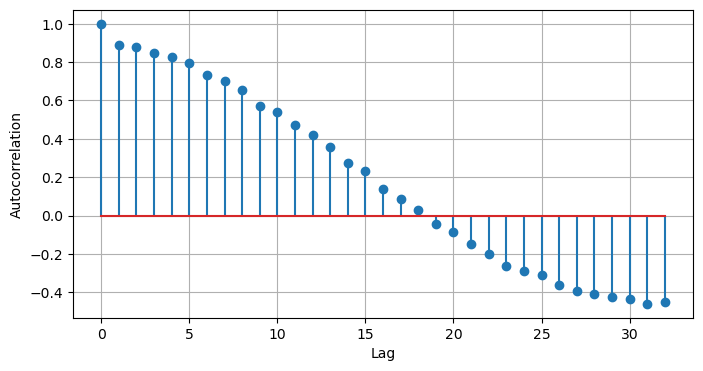

In [67]:
from statsmodels.tsa.stattools import acf

acf_values = acf(stm_train_noisy, nlags=32, fft=True)

plt.figure(figsize=(8, 4))
plt.stem(range(33), acf_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

## Next Steps

1. There are a lot of options -- especially regarding [kernel design](https://scikit-learn.org/dev/api/sklearn.gaussian_process.html#module-sklearn.gaussian_process.kernels) -- for the [Gaussian Process Regressor](https://scikit-learn.org/dev/api/sklearn.gaussian_process.html).  Review the different types of kernels and see if a different choice of kernel, or a different starting value for the hyperparameter, makes a difference in the quality of the model fits above. 
2. What happens if you specify a different initial length scale for the RBF kernel?  Does it make a difference at all in the fit or posterior hyperparameters? 
3. Experiment with setting the `alpha` values in the noise examples above intentionally to the 'wrong' value - how does this affect the posterior solution? 
4. Go through the CO2 fitting exercise using Gaussian Process Regression [here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html).  In addition to using a dataset we've used before, the design of the kernel shows how important and powerful this part of the procedure can be. 